In [1]:
import sys, os
ROOT = os.path.abspath("..")   # go up one directory from notebooks/
if ROOT not in sys.path:
    sys.path.append(ROOT)

print(ROOT)  


c:\Users\tdiks\Documents\PINN


In [2]:
from src2.networks import get_all_networks
from src2.config import CONFIG

from src2.sampling import (
    sample_domain_points,
    sample_top_surface,
    sample_interface,
    sample_far_field
)

from src2.losses import total_loss

from src2.pde_residuals import (
    residual_layer_coupled,
    residual_halfspace
)

from src2.boundary_conditions import (
    top_surface_bc,
    interface_layer_halfspace,
    halfspace_far_field_bc
)


# — Torch + Device

In [3]:
import torch
import torch.optim as optim

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Device: cpu


# Build-Models

In [4]:
model_layer, model_half = get_all_networks()

model_layer.to(DEVICE)
model_half.to(DEVICE)


PINN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Tanh()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Tanh()
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): Tanh()
    (10): Linear(in_features=128, out_features=128, bias=True)
    (11): Tanh()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): Tanh()
    (14): Linear(in_features=128, out_features=128, bias=True)
    (15): Tanh()
    (16): Linear(in_features=128, out_features=1, bias=True)
  )
)

# Load Config & Geometry

In [5]:
geom = CONFIG["GEOMETRY"]

params_layer = CONFIG["LAYER"]
params_half  = CONFIG["HALFSPACE"]
dispersion = []   # <-- DEFINE DISPERSION HERE


# Define trainable phase velocity (c)

In [6]:
c = torch.nn.Parameter(
    torch.tensor(
        (params_layer["mu44_0"] / params_layer["rho_0"])**0.5,
        device=DEVICE
    )
)


# Optimizer

In [7]:
optimizer = optim.Adam(
    list(model_layer.parameters()) +
    list(model_half.parameters()) +
    [c],
    lr=1e-3
)


# Training Loop (Simple + Transparent)

In [8]:
# Training Loop (Dispersion)
k_values = torch.linspace(
    CONFIG["GEOMETRY"]["k_min"],
    CONFIG["GEOMETRY"]["k_max"],
    CONFIG["GEOMETRY"]["num_k"]
)
k_values

tensor([0.0010, 0.0033, 0.0055, 0.0077, 0.0100])

In [9]:
dispersion = []   # <-- define once, BEFORE this block
for k in k_values:

    # Build-Models
    model_layer, model_half = get_all_networks()
    model_layer.to(DEVICE)
    model_half.to(DEVICE)

    # Define trainable phase velocity (c)
    c = torch.nn.Parameter(
        torch.tensor(
            (params_layer["mu44_0"] / params_layer["rho_0"])**0.5,
            device=DEVICE
        )
    )

    optimizer = optim.Adam(
        list(model_layer.parameters()) +
        list(model_half.parameters()) +
        [c],
        lr=1e-3
    )

    # -------- INNER TRAINING LOOP --------
    for epoch in range(1, 5000):

        z_layer, z_half = sample_domain_points(3000, geom)
        z_top = sample_top_surface(1000, geom)
        z_int = sample_interface(1000)
        z_far = sample_far_field(1000, geom)

        optimizer.zero_grad()

        loss, logs = total_loss(
            model_layer,
            model_half,
            z_layer,
            z_half,
            z_top,
            z_int,
            z_far,
            params_layer,
            params_half,
            k.item()* geom["H"],   # <-- correct
            c,
            w_pde=1.0,
            w_bc=0.1,
            w_int=0.1,
            w_far=0.001,
        )
    

        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(
                f"k={k.item():.2f} | "
                f"Epoch {epoch} | "
                f"Loss={loss.item():.3e} |"
                f"PDE={logs['pde']:.2e} | "
                f"BC={logs['bc_top']:.2e} | "
                f"INT={logs['interface']:.2e} | "
                f"FAR={logs['far']:.2e}"
            )

    
    dispersion.append([k.item(), c.item()])


k=0.00 | Epoch 100 | Loss=3.787e-11 |PDE=3.24e-11 | BC=1.50e-17 | INT=5.48e-11 | FAR=6.41e-13
k=0.00 | Epoch 200 | Loss=1.534e-11 |PDE=1.40e-11 | BC=2.54e-17 | INT=1.31e-11 | FAR=1.91e-14
k=0.00 | Epoch 300 | Loss=1.171e-11 |PDE=1.09e-11 | BC=2.35e-17 | INT=8.12e-12 | FAR=7.39e-15
k=0.00 | Epoch 400 | Loss=7.879e-12 |PDE=7.20e-12 | BC=1.93e-17 | INT=6.76e-12 | FAR=5.72e-15
k=0.00 | Epoch 500 | Loss=6.625e-12 |PDE=6.00e-12 | BC=1.81e-17 | INT=6.29e-12 | FAR=2.21e-15
k=0.00 | Epoch 600 | Loss=6.138e-12 |PDE=5.65e-12 | BC=1.76e-17 | INT=4.87e-12 | FAR=4.62e-15
k=0.00 | Epoch 700 | Loss=4.987e-12 |PDE=4.52e-12 | BC=1.92e-17 | INT=4.63e-12 | FAR=8.08e-15
k=0.00 | Epoch 800 | Loss=4.095e-12 |PDE=3.68e-12 | BC=2.18e-17 | INT=4.14e-12 | FAR=5.05e-15
k=0.00 | Epoch 900 | Loss=3.242e-12 |PDE=2.86e-12 | BC=2.47e-17 | INT=3.85e-12 | FAR=2.36e-15
k=0.00 | Epoch 1000 | Loss=2.898e-12 |PDE=2.58e-12 | BC=2.79e-17 | INT=3.18e-12 | FAR=1.61e-15
k=0.00 | Epoch 1100 | Loss=2.343e-12 |PDE=2.06e-12 | BC=3.1

In [10]:
torch.save({
    "model_layer": model_layer.state_dict(),
    "model_half": model_half.state_dict(),
    "c": c.detach().cpu()
}, "dispersion_pinn.pth")

print("Model saved.")


Model saved.


Choose time & y-location

In [11]:
import torch

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

H = geom["H"]   # layer thickness
L = geom["L"]   # half-space depth


Create a point in each layer

In [12]:
# z-grid for plotting / post-processing

z_layer = torch.linspace(-H, 0.0, 200).reshape(-1, 1).to(DEVICE)
z_half  = torch.linspace(0.0, L, 200).reshape(-1, 1).to(DEVICE)


Feed to model

In [13]:
with torch.no_grad():

    scale = 1e-2
# Layer (complex amplitude)   
    
V_layer = model_layer(z_layer)
V_R = scale * V_layer[:, 0:1]
V_I = scale * V_layer[:, 1:2]
# Half-space (real amplitude)
V_half = scale * model_half(z_half)



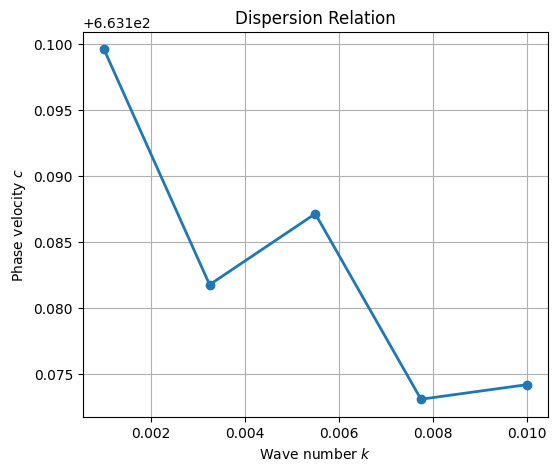

In [14]:
import matplotlib.pyplot as plt
import torch

# dispersion: shape (N, 2) → [k, c]
dispersion = torch.tensor(dispersion)
# dispersion: shape (N, 2) → [k, c]
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]


plt.figure(figsize=(6,5))
plt.plot(k_vals, c_vals, 'o-', linewidth=2, markersize=6)

plt.xlabel("Wave number $k$")
plt.ylabel("Phase velocity $c$")
plt.title("Dispersion Relation")
plt.grid(True)

plt.show()


Plot Disperion curves


C:\Users\tdiks\AppData\Local\Temp\ipykernel_26344\1561879266.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dispersion = torch.tensor(dispersion)


Layer properties:
  μ₆₆ = 5.00e+09 Pa
  ρ = 9890 kg/m³
  c_ref = √(μ₆₆/ρ) = 711.0 m/s
  H = 100


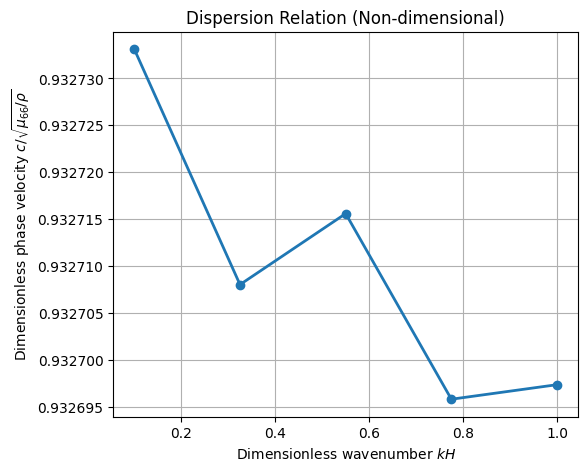


Dispersion data (non-dimensional):
   kH        c/c_ref
   0.100     0.933
   0.325     0.933
   0.550     0.933
   0.775     0.933
   1.000     0.933


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# Your dispersion data
dispersion = torch.tensor(dispersion)
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]

# Material properties for layer (from your config)
mu44_layer = 5.3e9  # Pa
rho_layer = 9890.0  # kg/m³
H = 100  # Layer thickness (non-dimensional)

# Calculate reference velocity: √(μ₆₆/ρ) for layer
c_ref_layer = np.sqrt(mu44_layer / rho_layer)  # Reference shear speed

print(f"Layer properties:")
print(f"  μ₄₄ = {mu44_layer:.2e} Pa")
print(f"  ρ = {rho_layer:.0f} kg/m³")
print(f"  c_ref = √(μ₄₄/ρ) = {c_ref_layer:.1f} m/s")
print(f"  H = {H}")

# Non-dimensionalize
kH = k_vals * H                     # Dimensionless wavenumber
c_norm = c_vals / c_ref_layer       # Dimensionless phase velocity

# Plot
plt.figure(figsize=(6, 5))
plt.plot(kH, c_norm, 'o-', linewidth=2, markersize=6)

plt.xlabel("Dimensionless wavenumber $kH$")
plt.ylabel("Dimensionless phase velocity $c/\\sqrt{\\mu_{66}/\\rho}$")
plt.title("Dispersion Relation (Non-dimensional)")
plt.grid(True)

plt.show()

# Print the data
print("\nDispersion data (non-dimensional):")
print("   kH        c/c_ref")
for i in range(len(kH)):
    print(f"   {kH[i]:.3f}     {c_norm[i]:.3f}")

C:\Users\tdiks\AppData\Local\Temp\ipykernel_26344\2954668902.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dispersion = torch.tensor(dispersion)


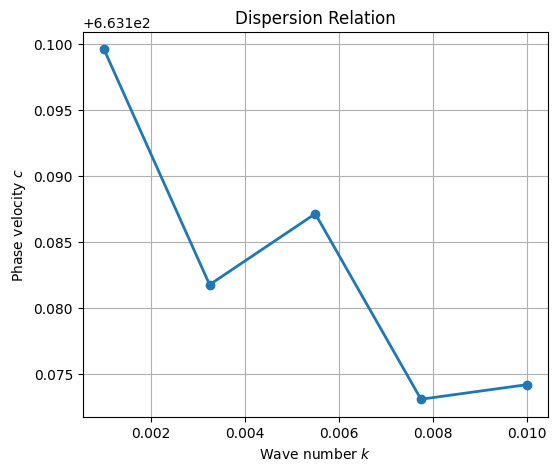

In [16]:
import matplotlib.pyplot as plt
import torch

# dispersion: shape (N, 2) → [k, c]
dispersion = torch.tensor(dispersion)
# dispersion: shape (N, 2) → [k, c]
k_vals = dispersion[:, 0]
c_vals = dispersion[:, 1]


plt.figure(figsize=(6,5))
plt.plot(k_vals, c_vals, 'o-', linewidth=2, markersize=6)

plt.xlabel("Wave number $k$")
plt.ylabel("Phase velocity $c$")
plt.title("Dispersion Relation")
plt.grid(True)

plt.show()


In [17]:
k_vals

tensor([0.0010, 0.0033, 0.0055, 0.0077, 0.0100])

In [18]:
c_vals

tensor([663.1996, 663.1818, 663.1871, 663.1731, 663.1742])

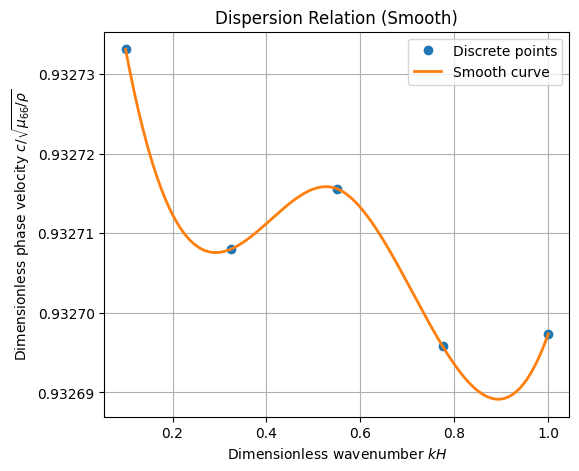

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# If not already done, convert tensors to numpy arrays
kH_np = kH.cpu().numpy() if hasattr(kH, 'cpu') else np.array(kH)
c_norm_np = c_norm.cpu().numpy() if hasattr(c_norm, 'cpu') else np.array(c_norm)

# Sort values for interpolation (required for spline)
sort_idx = np.argsort(kH_np)
kH_sorted = kH_np[sort_idx]
c_norm_sorted = c_norm_np[sort_idx]

# Create smooth curve using cubic spline
kH_smooth = np.linspace(kH_sorted.min(), kH_sorted.max(), 300)
spline = make_interp_spline(kH_sorted, c_norm_sorted, k=3)
c_norm_smooth = spline(kH_smooth)

# Plot both discrete points and smooth curve
plt.figure(figsize=(6, 5))
plt.plot(kH_sorted, c_norm_sorted, 'o', label='Discrete points')
plt.plot(kH_smooth, c_norm_smooth, '-', label='Smooth curve', linewidth=2)
plt.xlabel("Dimensionless wavenumber $kH$")
plt.ylabel("Dimensionless phase velocity $c/\\sqrt{\\mu_{66}/\\rho}$")
plt.title("Dispersion Relation (Smooth)")
plt.grid(True)
plt.legend()
plt.show()